<img src="https://swan.web.cern.ch/sites/swan.web.cern.ch/files/pictures/logo_swan_letters.png" alt="SWAN" style="float: left; width: 25%; margin-right: 15%; margin-left: 15%; margin-bottom: 2.0em;">
<img src="http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png" alt="EP-SFT" style="float: left; width: 25%; margin-right: 10%; margin-bottom: 2.0em;">
<p style="clear: both;">
# **Integration of SWAN with Spark clusters**
<hr style="border-top-width: 4px; border-top-color: #34609b;">

This notebook demonstrates the functionality provided by a SWAN prototype machine that allows to offload computations to an external Spark cluster. The Spark version we are going to use is 2.1.0 (included in the LCG_88 release) and we are going to connect to the Hadalytic cluster (as previously selected in the SWAN web form). 

In this example, we will query an HBase database and show some results. We will first acquire the necessary credentials to access the database.

In [1]:
import getpass
import os, sys

print("Please enter your password")
ret = os.system("echo %s | kinit" % getpass.getpass())

if ret == 0: print("Credentials created successfully")
else:        sys.stderr.write('Error creating credentials, return code: %s\n' % ret)

Please enter your password
········
Credentials created successfully


Second, we will download a couple of NXCALS jars that we need to query the database. Note that **these jars could be placed on CVMFS**, so that this step would not be necessary.

In [2]:
%%bash
wget -N -q https://etejedor.web.cern.ch/etejedor/nxcals/hortonworks-shc-core-cern-1.0.3-2.1-s_2.11-CERN.jar
wget -N -q https://etejedor.web.cern.ch/etejedor/nxcals/accsoft-nxcals-data-access-0.0.1.jar

Next, some Spark imports.

In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

Now we will do some configuration for the Spark driver to work from inside the user container. We will also define the necessary jars (note that the HBase jars are already located on CVMFS).

It is worth pointing out that **this configuration step could be automatized**: the user could receive a ``conf`` object with all these parameters already set and eventually configure other parameters like the number of executors.

In [4]:
conf = SparkConf()
conf.set('spark.driver.host', os.environ['SERVER_HOSTNAME'])
conf.set('spark.driver.port', os.environ['SPARK_PORT_1'])
conf.set('spark.fileserver.port', os.environ['SPARK_PORT_2'])
conf.set('spark.blockManager.port', os.environ['SPARK_PORT_3'])
conf.set('spark.ui.enabled', 'false')
conf.set('spark.master', 'yarn')
conf.set('spark.jars', './accsoft-nxcals-data-access-0.0.1.jar,./hortonworks-shc-core-cern-1.0.3-2.1-s_2.11-CERN.jar')
conf.set('spark.driver.extraClassPath', '{HBASE_LIB_DIR}/hbase-client-1.2.0.jar:{HBASE_LIB_DIR}/hbase-common-1.2.0.jar:{HBASE_LIB_DIR}/hbase-protocol-1.2.0.jar:{HBASE_LIB_DIR}/htrace-core-3.1.0-incubating.jar:{HBASE_LIB_DIR}/metrics-core-2.2.0.jar'.format(HBASE_LIB_DIR='/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/dev3/Tue/hbase/1.2.0/x86_64-slc6-gcc49-opt/lib'))
sc = SparkContext(conf = conf)
spark = SparkSession(sc)

Once Spark is configured, we can go ahead and query the database. First we show a pandas table containing some ALICE monitoring acquisition data.

In [5]:
import time
import calendar

In [6]:
df1 = spark.read.options(system="CMW",device="RADMON.ALICE10",property="ExpertMonitoringAcquisition",start_time=str((calendar.timegm(time.gmtime())-84600)*1000000000),end_time=str(calendar.timegm(time.gmtime())*1000000000)).format("cern.accsoft.nxcals.data.access.api").load()
df1.select('acqStamp','voltage_18V','current_18V').toPandas()[:10]

,acqStamp,voltage_18V,current_18V
0,1490369790541483000,19.868026,NaN
1,1490369789741171000,19.864980,38.249340
2,1490369788940953000,19.869550,38.157944
3,1490369788140636000,19.868026,38.264573
4,1490369787340372000,NaN,38.127478
5,1490369786540113000,19.866503,38.234107
6,1490369785739751000,19.871073,38.188409
7,1490369784939547000,NaN,38.279805
8,1490369784139302000,19.868026,38.264573
9,1490369783339020000,19.872596,38.218874


Now a time series plot with matplotlib.

In [7]:
import matplotlib
%matplotlib inline

/cvmfs/sft.cern.ch/lcg/releases/matplotlib/1.5.1-763af/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


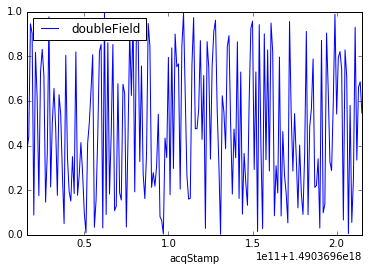

In [8]:
df2 = spark.read.options(system="CMW",device="NXCALS_LHC_DEV1",property="Logging",start_time=str((calendar.timegm(time.gmtime())-84600)*1000000000),end_time=str(calendar.timegm(time.gmtime())*1000000000)).format("cern.accsoft.nxcals.data.access.api").load()
df2.select('acqStamp','doubleField').toPandas()[:200].sort_values(by='acqStamp').plot(x='acqStamp');